# 06 - Item-based KNN with Normalization
This notebook develops our neighborhood-based algorithm - k-nearest neighbor with normalization. We use the KNNWithZScore module from Surprise and choose MAE as the performance measure. We again use fmin from Hyperopt to optimize the hyperparameters. Similar to the previous models, we perform a runtime analysis in the second part of this notebook.

In [5]:
from surprise import Dataset, evaluate, KNNWithZScore, Reader

from hyperopt import tpe, fmin, hp, Trials, STATUS_OK

import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

sns.set(style='whitegrid')
% matplotlib inline

In [6]:
# set file paths and read in samples
data_path = os.path.join('..','..','data')
data_file_100 = os.path.join(data_path, 'reviews_sample_100.csv')
data_file_50 = os.path.join(data_path, 'reviews_sample_50.csv')
data_file_25 = os.path.join(data_path, 'reviews_sample_25.csv')
data_file_10 = os.path.join(data_path, 'reviews_sample_10.csv')

df_100 = pd.read_csv(data_file_100).drop('Unnamed: 0', axis = 1)
df_50 = pd.read_csv(data_file_50).drop('Unnamed: 0', axis = 1)
df_25 = pd.read_csv(data_file_25).drop('Unnamed: 0', axis = 1)
df_10 = pd.read_csv(data_file_10).drop('Unnamed: 0', axis = 1)

In [7]:
reader = Reader(rating_scale=(1,5))
sdf_100 = Dataset.load_from_df(df_100[['reviewerID', 'asin', 'overall']], reader=reader)

Surprise's KNNwithZScore model can be tuned with three hyperparameters:
1. k: the maximum number of nearest neighbors used to calculate a prediction
2. min_k: the minimum number of neighbors necessary for a prediction to be possible
3. name: the name of the similarity metric used to determine neighrest neighbors as well as calculate predictions

To search for optimal hyperparameter values, we eschew grid search for a more efficient and effective Bayesian optimization method using **tree parzen estimators** provided by the Hyperopt library.

In [8]:
def test_knn(params): 
    '''Test KNNWithZScore with specified hyperparameter settings and define cross-validated MAE as loss.
       This function will later be fed into fmin to find optimized hyperparameters.
    '''
    k = params['k']
    min_k = params['min_k']
    
    '''Item-based similarity chosen for this model.
       In addition, similarity between two items will be set to zero if number of common users
       per item is less than 5.
    '''
    sim_options = dict(name = params['name'], min_support = 5, user_based = False)
    
    # split the dataset into three folds for cross-validation
    model = KNNWithZScore(k=k, min_k=min_k, sim_options=sim_options)
    sdf_100.split(3, shuffle=True)
    results = evaluate(model, sdf_100, measures = ['mae'], verbose=True)
    mae = np.array(results['mae']).mean()
    return mae

In [9]:
use_pretrained = True

if use_pretrained:
    with open(os.path.join(data_path, 'trials_knn'), 'rb') as file_in:
        trials = pkl.load(file_in)
else:
    
    # set the range of hyperpatameters for the KNN model
    trials = Trials()
    space = {
        'k': hp.choice('k', list(range(20, 61))),
        'min_k': hp.choice('min_k', list(range(1,6))),
        'name': hp.choice('name', ['pearson', 'msd', 'cosine'])
    }
    
    '''Use Tree-structured Parzen Estimator (TPE) as the algorithm used
       to optimize the objective function'''
    best = fmin(algo = tpe.suggest,
               fn = test_knn,
               trials = trials,
               max_evals = 100,
               space = space)
    with open(os.path.join(data_path, 'trials_knn'), 'wb') as file_out:
        pkl.dump(trials, file_out)

This section below, accompanied by various graphs, visulizes the distribution of the different values each hyperparameter can take and the corresponding loss values.

In [10]:
def val_diagnostic(val_name, trials):
    vals = np.array([trial['misc']['vals'][val_name] for trial in trials.trials])
    ts = [trial['tid'] for trial in trials.trials]
    results = [trial['result']['loss'] for trial in trials.trials]
    
    if val_name == 'min_k':
        vals += 1
    
    fig, axes = plt.subplots(1, 3, figsize = (16,4))
    axes[0].scatter(ts, vals)
    axes[0].set(xlabel='iteration', ylabel=val_name)
    axes[1].hist(np.array(vals).squeeze())
    axes[1].set(xlabel=val_name, ylabel='frequency')
    axes[2].scatter(vals, results)
    axes[2].set(xlabel=val_name, ylabel='loss')
    
    if val_name == 'name':
        axes[0].set(yticks = [0,1,2], yticklabels = ['pearson','msd','cosine'], ylabel = 'similarity')
        axes[1].set(xticks = [0,1,2], xticklabels = ['pearson','msd','cosine'], xlabel = 'similarity')
        axes[2].set(xticks = [0,1,2], xticklabels = ['pearson','msd','cosine'], xlabel = 'similarity')
    
    plt.tight_layout()

For each hyperparameter, namely k, min_k, and the similarity metric, we make three plots to understand its distribution and performance. The first and second graphs are respectively a scatterplot and a histogram, in order to visualize where the values tend to cluster as the algorithm optimizes. The third graph is a loss vs. values plot that visualizes how MAE changes with different values. The algorithm picks the combination of hyperparameter values where loss is minimized.

As we can see from the graphs, the model tends to do better when the max number of neighbors is around 35 and the minimum number of neighbors is around 1. In terms of similarity, mean squared difference (MSD) significantly lowers loss in comparison to pearson, and also performs slightly better than cosine.

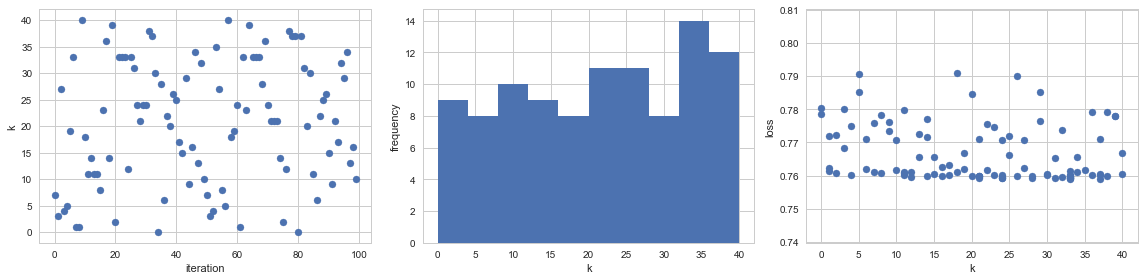

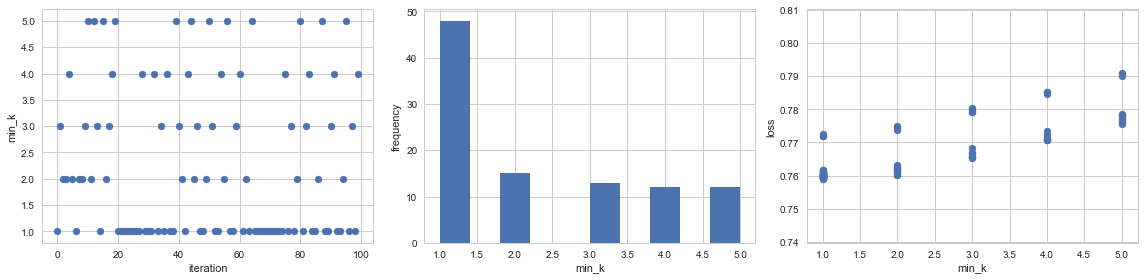

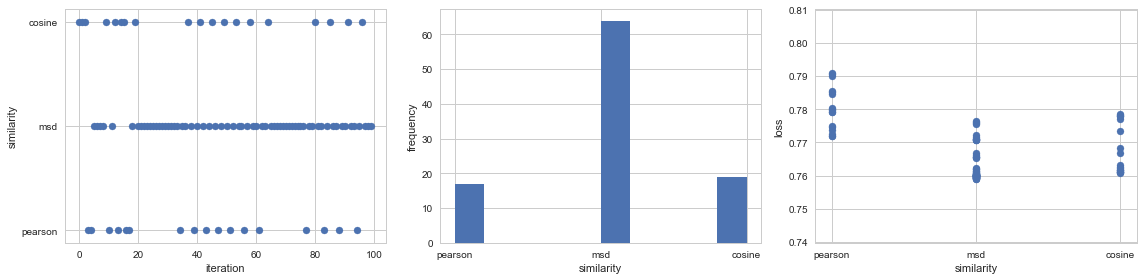

In [11]:
for val in trials.trials[0]['misc']['vals'].keys():
    val_diagnostic(val, trials)

In [12]:
# optimized hyperparameter values

use_pretrained = True

if use_pretrained:
    with open(os.path.join(data_path, 'best_knn.dict'), 'rb') as file_in:
        best_adjusted = pkl.load(file_in)
else:
    best_adjusted = best.copy()
    best_adjusted['min_k'] += 1
    best_adjusted['name'] = 'msd'
    with open(os.path.join(data_path, 'best_knn.dict'), 'wb') as file_out:
        pkl.dump(best_adjusted, file_out)
        
print(best_adjusted)

{'k': 37, 'min_k': 1, 'name': 'msd'}


In [13]:
# feed in optimized hyperparameters to KNN and evaluate 5-fold cross-validated MAE
use_pretrained = True

if use_pretrained:
    with open(os.path.join(data_path, 'results_knn.array'), 'rb') as file_in:
        results = pkl.load(file_in)
else:
    sim_options = dict(name = best_adjusted['name'], min_support = 5, user_based = False)
    model = KNNWithZScore(k = best_adjusted['k'], min_k = best_adjusted['min_k'], sim_options = sim_options)
    # split the dataset into 5 folds for cross-validation
    sdf_100.split(5)
    results = evaluate(model, sdf_100, measures = ['mae'])
    with open(os.path.join(data_path, 'results_knn.array'), 'wb') as file_out:
        pkl.dump(results, file_out)

Using the optimized hyperparameters, we find the median MAE of the KNN model to be around 0.7365.

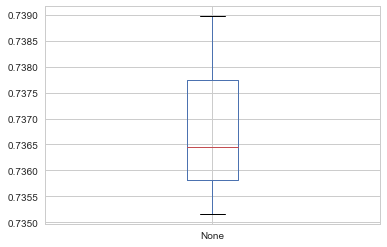

In [14]:
pd.Series(results['mae']).plot(kind = 'box')

# Runtime analysis
In this part of the notebook, we run the KNN model with different sample sizes in order to explore how runtime scales as sample size increases. For each sample size, we run the model for 1 iteration, and record the difference between start time and end time.

In [15]:
'''run the KNN model on different samplze sizes and calculate runtimes'''
df_list = [df_10, df_25, df_50, df_100]

use_pretrained = True

if use_pretrained:
    with open(os.path.join(data_path, 'runtime_knn.list'), 'rb')as file_in:
        runtime_list = pkl.load(file_in)
else:
    runtime_list = list()
    for df in df_list:
        sdf = Dataset.load_from_df(df[['reviewerID', 'asin', 'overall']], reader=reader)
        
        # use the entire dataset without splitting into folds
        train = sdf.build_full_trainset()

        start = time.time()
        model.train(train)
        end = time.time()

        runtime_list.append(end-start)

    with open(os.path.join(data_path, 'runtime_knn.list'), 'wb')as file_out:
        pkl.dump(runtime_list, file_out)

Here we observe that, for the KNN model with normalization, the relationship between runtime and sample size slightly exhibits a quadratic pattern.

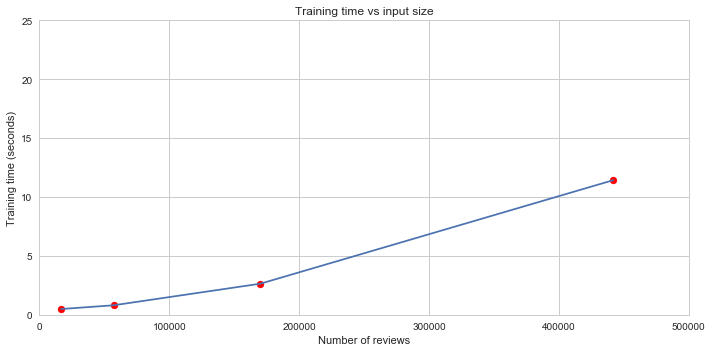

In [16]:
# plot runtime against sample sizes
n_reviews_list = [len(df) for df in df_list]
plt.figure(figsize = (10, 5))
plt.plot(n_reviews_list, runtime_list)
plt.scatter(n_reviews_list, runtime_list, color = 'red')
plt.ylim(0, 25)
plt.xlim(0, 500000)
plt.xlabel('Number of reviews')
plt.ylabel('Training time (seconds)')
plt.title('Training time vs input size')
plt.tight_layout()